# Sloan (2004), Weber (2018)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
from sklearn import linear_model
from statsmodels.iolib.summary2 import summary_col
import matplotlib.ticker as mtick
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Data Cleansing

Financial statement data comes from COMPUSTAT. I derive the necessary variables and make minor adjustments as per Sloan (2004), Weber (2018).

In [2]:
data = pd.read_csv("Sloan.csv")
data.iloc[:,3:-2] = data.iloc[:,3:-2]*1e6

data["bvps"] = data[["pstk", "pstkl", "pstkrv"]].max(axis=1)
data["be"] = data["seq"] + data["txditc"] - data["bvps"]

data["me"][data["me"]<=0.] = np.nan
data["be"][data["be"]<=0.] = np.nan
data["be"][data["be"]>data["me"]*50] = np.nan
data["be"][data["be"]<data["me"]/50] = np.nan
data_clean = data[["fyear", "tic", "me", "be", "ib", "sale", "eps"]]
data_clean["fyear"] = pd.to_datetime(data_clean["fyear"], format='%Y')
data_clean = data_clean.set_index(data_clean["fyear"])
del data_clean["fyear"]

The four variables required for each stock are: **growth in equity**, **ROE**, **sales growth** and **market equity**.

In [3]:
stocks = []
tickers = data_clean["tic"].unique()
for i in tickers:
    stocks.append(data_clean.where(data_clean["tic"]==i).dropna())

date_index = pd.date_range("1979/01/01", periods=40, freq='Y')
date_index += datetime.timedelta(days=1)
temp =[]
for i in stocks:
    i = i[~i.index.duplicated()]
    i = i.reindex(date_index)
    if(i.isna().sum().sum()<=40*4):
        i["EG"] = (i["be"] - i["be"].shift()).div(i["be"].shift(), fill_value=np.nan)
        i["ROE"] = (i["ib"]).div(i["be"].shift(), fill_value=np.nan)
        i["SG"] = i["sale"].pct_change(fill_value=np.nan)
        i["eps_growth"] = i["eps"].pct_change().ffill(limit=1)
        i.iloc[:,1:] = i.iloc[:,1:].clip(lower=i.iloc[:,1:].quantile(0.01), upper=i.iloc[:,1:].quantile(0.99), axis=1)
        i = i.replace([np.inf, -np.inf], np.nan)
        i = i.shift()
        temp.append(i)

stocks=temp   

## Duration Derivation

In order to forecast expected cashflows, future ROE and equity growth need to be estimated. Sloan/Weber assume that both ROE and equity growth follow an AR(1) process. The long-term values (i.e. intercept) for ROE and equity growth are assumed to be 12% and 6%, respectively. 

Below, the autocorrelation coefficients are estimated using expanding windows. The coefficients are almost identical to those in Weber (ROE = 0.41, equity growth = 0.24).

The duration formula is split into two components:
- A finite forecasting horizon $t =1, \ldots,T$, in which variables follow an AR(1) process.
- A subsequent infinite horizon beyond which cashflows are assumed to behave as a level perpetuity.




$$\large D = \frac{\sum_{t=1}^T t \times \frac{CF_t}{(1+r)^t}}{P} + \big(T + \frac{1+r}{r}\big)\times  \frac{P - \sum_{t=1}^T t \times \frac{CF_t}{(1+r)^t}}{P}$$

In [4]:
def SloanDuration(data, start_date=18, Rolling_AR=False, ROE_coef=.41, Earnings_coef=.24):
    subset= data.copy()
    perpetuity_duration = 10. + (1.+0.12)/0.12
  
    duration=[]
    for j in range(start_date, data[0].shape[0]):
            
        ROE_slope = []
        ROE_weight = 0.
        EG_slope = []
        EG_weight = 0.
        
        for i in range(len(subset)):
            subset[i] = data[i].iloc[:j,:] 
        
        cross_section = pd.DataFrame(index=[date_index[j]], columns = tickers)
        for i in subset:
            if Rolling_AR:
                
                try:
                    ROE_weight +=len(i["ROE"].dropna())
                    model = ARMA(i["ROE"], order=(1,0), missing="drop", dates = i["ROE"].index)
                    AR1_res = model.fit()
                    ROE_slope.append(AR1_res.params[1]*len(i["ROE"].dropna()))

                    EG_weight +=len(i["SG"].dropna())
                    model = ARMA(i["SG"], order=(1,0), missing="drop", dates = i["SG"].index)
                    AR1_res = model.fit()
                    EG_slope.append(AR1_res.params[1]*len(i["SG"].dropna()))

                except ValueError: #Not enough observations
                    continue

                ROE = np.asarray(ROE_slope).sum()/ROE_weight
                EG = np.asarray(EG_slope).sum()/EG_weight
                
            else:
                ROE = ROE_coef
                EG = Earnings_coef

            ROE_growth =  [i["ROE"][-1]]
            EG_growth =  [i["SG"][-1]]
            BV=  [i["be"][-1]]
            E =  [i["ib"][-1]]
            PVCF = []
            PVCF_t = []
            for k in range(10):
                ROE_growth.append(.12*(1.-ROE)+ROE_growth[-1]*ROE)
                EG_growth.append(.06*(1.-EG)+EG_growth[-1]*EG)
                E.append(ROE_growth[-1]*BV[-1])
                BV.append((EG_growth[-1]*BV[-1]) + BV[-1])
                PVCF.append((E[-1] - (BV[-1] - BV[-2]))/(1.12)**(k+1))
                PVCF_t.append(PVCF[-1]*(k+1))

            finite_duration = np.asarray(PVCF_t).sum()/np.asarray(PVCF).sum()
            weight = np.asarray(PVCF).sum()/i["me"][-1]
            implied_duration = weight*finite_duration +(1. - weight)*perpetuity_duration
            try:
                cross_section[i["tic"].dropna().unique()[0]] = implied_duration
            except IndexError: #cross_section only contains nans
                continue
                
        duration.append(cross_section)
        
    duration = pd.concat(duration)
    duration.to_csv("SloanDuration.csv")

Under certain simplifying assumptions about the growth in expected cashflows, Sloan derives two approximations to equity duration - both of which are closely linked to the value factor. The first approximation derives a formula for duration in terms of earnings-to-price. The second approximation derives a duration formula in terms of book-to-market.

$$\large D_{E/P} = T + \frac{1+r}{r} - \frac{E}{P} \times \frac{T}{r}$$
$$\quad$$
$$\quad$$
$$\large D_{B/M} = T + \frac{1+r}{r} - \frac{BV}{P}\times T$$

In [5]:
def EarningsToPriceEstimator(data,start_date=18):
    subset= data.copy()
    T = 10.
    r = .12
    perpetuity_duration = T + (1.+r)/r
  
    duration=[]
    for j in range(start_date, data[0].shape[0]):
                    
        for i in range(len(subset)):
            subset[i] = data[i].iloc[:j,:] 
            
        cross_section = pd.DataFrame(index=[date_index[j]], columns = tickers)
        for i in subset:
            finite_duration = - i["ib"][-1]/i["me"][-1]*(T/r)
            implied_duration = perpetuity_duration + finite_duration
            try:
                cross_section[i["tic"].dropna().unique()[0]] = implied_duration
            except IndexError:
                continue
                
        duration.append(cross_section)

    duration = pd.concat(duration)
    return duration

In [6]:
def BookToMarketEstimator(data,start_date=18):
    subset= data.copy()
    T = 10.
    r = .12
    perpetuity_duration = T + (1.+r)/r
  
    duration=[]
    for j in range(start_date, data[0].shape[0]):
        
        for i in range(len(subset)):
            subset[i] = data[i].iloc[:j,:] 
            
        cross_section = pd.DataFrame(index=[date_index[j]], columns = tickers)
        for i in subset:
            finite_duration = - i["be"][-1]/i["me"][-1]*T
            implied_duration = perpetuity_duration + finite_duration
            try:
                cross_section[i["tic"].dropna().unique()[0]] = implied_duration
            except IndexError:
                continue
                
        duration.append(cross_section)

    duration = pd.concat(duration)
    return duration

In [7]:
#SloanDuration(stocks, 18,Rolling_AR=True)
duration = pd.read_csv("SloanDuration.csv", index_col=0)
duration.index = pd.to_datetime(duration.index)

duration_EP = EarningsToPriceEstimator(stocks,18)
duration_BM = BookToMarketEstimator(stocks,18)

The summary statistics below are very similar to those presented in Sloan (2004).

In [8]:
summary = pd.concat((duration.describe().mean(axis=1),duration_BM.describe().mean(axis=1), duration_EP.describe().mean(axis=1)), axis=1)
summary = np.round(summary.rename(columns={0: 'Duration Original',1: 'Duration_BM',2: 'Duration_EP'}),2)
summary

,Duration Original,Duration_BM,Duration_EP
count,15.24,19.55,14.52
mean,15.71,13.07,15.07
std,3.26,3.24,3.85
min,6.16,4.65,8.17
25%,15.19,11.84,13.20
50%,16.25,13.72,14.81
75%,17.09,15.11,16.63
max,19.65,16.73,23.32


Looking at rank correlations, we see that Sloan's original cashflow model and the two value-based approximations are highly correlated.

In [9]:
T = 10.
r = .12
BM = (T + (1.+r)/r - duration_BM)/T
EP = (T + (1.+r)/r - duration_EP)*r/T

duration_corr = pd.concat(( duration.stack(), duration_EP.stack().astype('float'),duration_BM.stack().astype('float'),BM.stack().astype('float'),EP.stack().astype('float')), axis=1)
duration_corr = duration_corr.rename(columns={0: 'Duration',1: 'Duration_EP',2: 'Duration_BM',3: 'BM', 4: 'EP'})
duration_corr = duration_corr.reset_index()
corr = round(duration_corr.corr('spearman'),3)
corr.style.background_gradient()

,Duration,Duration_EP,Duration_BM,BM,EP
Duration,1,0.346,0.72,-0.72,-0.346
Duration_EP,0.346,1,0.247,-0.247,-1
Duration_BM,0.72,0.247,1,-1,-0.247
BM,-0.72,-0.247,-1,1,0.247
EP,-0.346,-1,-0.247,0.247,1


In [10]:
duration_corr = pd.concat(( duration.stack(), duration_EP.stack().astype('float'),duration_BM.stack().astype('float'),BM.stack().astype('float'),EP.stack().astype('float')), axis=1)
duration_corr = duration_corr.rename(columns={0: 'Duration',1: 'Duration_EP',2: 'Duration_BM',3: 'BM', 4: 'EP'})
duration_corr = duration_corr.reset_index()
corr = round(duration_corr.corr(),3)
corr.style.background_gradient()

,Duration,Duration_EP,Duration_BM,BM,EP
Duration,1,0.154,0.572,-0.572,-0.154
Duration_EP,0.154,1,0.087,-0.087,-1
Duration_BM,0.572,0.087,1,-1,-0.087
BM,-0.572,-0.087,-1,1,0.087
EP,-0.154,-1,-0.087,0.087,1


Below are the main datasets required for the analysis:

In [11]:
daily_returns = pd.read_csv("DailyStockReturns.csv", index_col=0)
daily_returns.index = pd.to_datetime(daily_returns.index)
daily_returns = daily_returns.T.drop_duplicates().T
daily_returns = daily_returns.iloc[:5501,:]

duration = pd.read_csv("SloanDuration.csv", index_col=0)
duration.index = pd.to_datetime(duration.index)

market_cap = pd.read_csv("MarketCapMonthly.csv", index_col=0)
market_cap.index = pd.to_datetime(market_cap.index)
market_cap = market_cap[market_cap.columns.intersection(daily_returns.columns)]
weights = market_cap.resample('B').ffill(limit=30)
weights = pd.DataFrame(weights, columns=weights.columns, index=daily_returns.index)

signal = -1*duration.dropna(how='all', axis=[0,1])
quintiles = signal.apply(lambda x: pd.qcut(x, 5, labels=range(5, 0, -1)), axis=1)
quintiles = quintiles.resample('B').first().ffill(limit=260)

EPS = pd.read_csv("GrowthData.csv", index_col=0)
EPS.index = pd.to_datetime(EPS.index)
EPS = EPS[EPS.columns.intersection(duration.columns)]

factors = pd.read_csv("factors.csv", index_col=0)
factors.index = pd.to_datetime(factors.index)

## Testing Sloan (2004) Hypotheses

The first hypothesis tested by Sloan is that the volatility of holding period returns is positively correlated with duration. We look at the correlation between equity duration and two-year rolling historical volatility. There is positive correlation between volatility and duration. The same result holds when considering betas - as expected. Results are similar to those in Sloan.

In [13]:
monthly = factors.resample('M').mean()*12 
market = monthly["mktrf"]
monthly_returns = daily_returns[duration.columns].resample('M').mean()*12
duration_monthly = duration.resample('B').last().ffill(limit=260)
duration_monthly = duration_monthly.reindex(monthly_returns.index, method = "nearest")

rolling_vol = pd.DataFrame(index=monthly_returns.index, columns= monthly_returns.columns)
rolling_betas = pd.DataFrame(index=monthly_returns.index, columns= monthly_returns.columns)
period = 24

for i in rolling_vol.columns:
    rolling_vol[i] = (monthly_returns[i].rolling(period, min_periods = int(period/2) ).std())
    rolling_betas[i] = (monthly_returns[i].rolling(period, min_periods = int(period/2)).corr(market, pairwise = True)/market.rolling(period, min_periods = int(period/2)).std())*monthly_returns[i].rolling(period, min_periods = int(period/2)).std()
    
vol = pd.concat((duration_monthly.stack(dropna=False), rolling_vol.stack(dropna=False), rolling_betas.stack(dropna=False)), axis=1).dropna()
vol = vol.rename(columns={0: 'Duration',1: 'Rolling_Vol',2: 'Rolling_Betas'})
corr = round(vol.corr(),3)
corr.style.background_gradient()

,Duration,Rolling_Vol,Rolling_Betas
Duration,1,0.134,0.084
Rolling_Vol,0.134,1,0.291
Rolling_Betas,0.084,0.291,1


In [14]:
corr = round(vol.corr("spearman"),3)
corr.style.background_gradient()

,Duration,Rolling_Vol,Rolling_Betas
Duration,1,0.106,0.057
Rolling_Vol,0.106,1,0.407
Rolling_Betas,0.057,0.407,1


The next hypothesis concerns the relationship between current implied duration and future return volatility. Rather than looking purely at correlations, Sloan follows a regression approach which allows for the inclusion of 2-year historical vols as predictors of future vols. If duration has predictive power, we should find a statistically significant relationship - even after accounting for historical vols.

In [15]:
lagged_vol = rolling_vol.shift(24).stack(dropna=False)
lagged_betas = rolling_betas.shift(24).stack(dropna=False)
lagged_duration = duration_monthly.shift(24).stack(dropna=False)

vol = rolling_vol.stack(dropna=False)
betas = rolling_betas.stack(dropna=False)

In [18]:
results =[]
y1 = vol
y2 = betas

X1 = pd.concat((lagged_vol, lagged_duration/1e3), axis=1)
X1 = sm.add_constant(X1)
X1 = X1.rename(columns={"const": 'intercept',0: 'lagged vol',1: 'lagged duration'})

X2 = lagged_duration/1e3
X2= sm.add_constant(X2)
X2 = X2.rename(columns={"const": 'intercept',0: 'lagged duration'})

X3 = pd.concat((lagged_betas, lagged_duration/1e3), axis=1)
X3 = sm.add_constant(X3)
X3 = X3.rename(columns={"const": 'intercept',0: 'lagged beta',1: 'lagged duration'})

X4 = lagged_duration/1e3
X4 = sm.add_constant(X4)
X4 = X4.rename(columns={"const": 'intercept',0: 'lagged duration'})

for i in [X1,X2]:
    results.append(sm.OLS(y1, i, missing='drop').fit())
    
    
X3 = pd.concat((lagged_betas, lagged_duration/1e2), axis=1)
X3 = sm.add_constant(X3)
X3 = X3.rename(columns={"const": 'intercept',0: 'lagged beta',1: 'lagged duration'})

X4 = lagged_duration/1e2
X4 = sm.add_constant(X4)
X4 = X4.rename(columns={"const": 'intercept',0: 'lagged duration'})

for i in [X3,X4]:
    results.append(sm.OLS(y2, i, missing='drop').fit())
    

info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results= results,
                            float_format='%0.3f',
                            stars = True,
                            model_names = ["vol","vol ","beta","beta "],
                            regressor_order = ["intercept","lagged vol","lagged beta","lagged duration"],
                            info_dict=info_dict)
print(results_table)


                   vol      vol      beta    beta   
----------------------------------------------------
intercept        0.033*** 0.046*** 0.605*** 0.845***
                 (0.000)  (0.000)  (0.008)  (0.008) 
lagged vol       0.309***                           
                 (0.004)                            
lagged beta                        0.365***         
                                   (0.003)          
lagged duration  0.303*** 0.699*** 0.277*** 0.862***
                 (0.028)  (0.028)  (0.048)  (0.050) 
R-squared        0.07     0.01     0.13     0.00    
No. observations 102638   108692   102638   108692  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


Finally, Sloan derives a simplified approximation to the equity yield curve. Duration is assumed to approximate the maturity of an equity security. Furthermore, Sloan relies on the theory of rational expectations -- anticipated and realized yields converge over long periods of time.

Observations are partitioned into duration categories (<0, 0-5, 5-10, 10-15, 15-20, >20 years) and the average 12-month return for each category is computed. The return period begins four months after the duration-ranking.

In [19]:
def SloanYieldCurve(daily_returns, duration, weights, value_weighted = False):
    bins = [0,5,10,15,20, 2000]
    signal = duration.dropna(how='all', axis=[0,1])
    signal = signal.apply(lambda x: pd.cut(x, bins, labels=range(5, 0, -1)), axis=1)

    
    daily_returns = daily_returns[signal.columns]
    daily_duration = duration.dropna(how='all', axis=[0, 1]).resample('B').first().ffill(limit=260)
    daily_duration = daily_duration.reindex(daily_returns.index, method = "nearest")
    signal = signal.reindex(daily_returns.index, method = "nearest")

    if(value_weighted):
        weights = weights[signal.columns]
        quintile_weights = dict()
        for q in range(1,6):
            q_weights = pd.DataFrame((signal == q).astype(int).values*weights.values, columns=weights.columns, index=weights.index)
            q_weights = q_weights.div(q_weights.sum(axis=1), axis=0)
            quintile_weights[q] = q_weights
        quintile_weights = pd.concat(quintile_weights, axis=1).dropna(how='all', axis=[0, 1])
        
    else:
        quintile_weights = dict()
        for q in range(1, 6):
            q_weights = (signal == q).astype(int)
            q_weights = q_weights.div(q_weights.sum(axis=1), axis=0)
            quintile_weights[q] = q_weights.resample('B').ffill(limit=7)
        quintile_weights = pd.concat(quintile_weights, axis=1).dropna(how='all', axis=[0, 1])

    future_returns = quintile_weights.mul(daily_returns.shift(90), axis=0, level=1).sum(axis=1, level=0, min_count=1)
    quintile_duration = quintile_weights.mul(daily_duration, axis=0, level=1).sum(axis=1, level=0, min_count=1)

    #plot
    dur = quintile_duration.resample('A').mean()
    ret = future_returns.resample('A').mean()*26000
    fig = plt.figure(1, (11,5))
    ax = fig.add_subplot(1,1,1)
    plt.plot(dur.mean(axis=0),ret.mean(axis=0))
    plt.title("Estimated Equity Yield Curve, Sloan (2004)")
    plt.xlabel("Maturity (years)")
    plt.ylabel("Annual Yield")
    plt.grid()
    fmt = '%.0f%%'
    yticks = mtick.FormatStrFormatter(fmt)
    ax.yaxis.set_major_formatter(yticks);

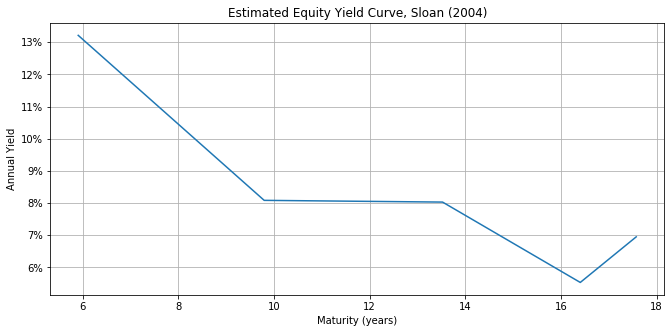

In [20]:
duration = pd.read_csv("SloanDuration.csv", index_col=0)
duration.index = pd.to_datetime(duration.index)

SloanYieldCurve(daily_returns, duration, weights)

## Testing Weber (2018) Hypotheses

Weber argues that any anomaly should be stronger following periods of high investor sentiment if mispricing is the cause of the anomaly. In high sentiment periods, investors tend to be over-optimistic, leading to temporal mispricings. Therefore, we should expect larger returns to the duration strategy following periods of high investor sentiment. Sentiment data comes from the Baker and Wurgler (2006) database (http://people.stern.nyu.edu/jwurgler/). The data is in the form of a composite sentiment index that is based on six sentiment proxies: the closed‐end fund discount, NYSE share turnover, the number and average first‐day returns on IPOs, the equity share in new issues, and the dividend premium.

Low duration quintiles are positively exposed to sentiment. High duration quintiles are not. The duration factor is positively exposed to sentiment (statistically significant at 90% level).

In [32]:
sentiment = pd.read_csv("sentiment.csv", index_col=0)
sentiment.index = pd.to_datetime(sentiment.index)
sentiment= sentiment["SENT1"].diff().rolling(window=12).mean()
sentiment = sentiment.reindex(monthly.index)

monthly = FamaFrenchCorrelations(factors, quintile_returns, quintile_weights, daily_returns)
monthly["high"] = sentiment
quintile_monthly = quintile_returns.resample("M").mean()*12
quintile_monthly = quintile_monthly.reindex(monthly.index)

In [33]:
def Weber_regression(x_vals, estimate, deciles=False):
    results =[]
    X = monthly[x_vals]
    X = sm.add_constant(X)

    for i in [1,2,3,4,5, estimate]:
        results.append(sm.OLS(quintile_monthly[i], X, missing='drop').fit())

    info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

    results_table = summary_col(results= results,
                            float_format='%0.3f',
                            stars = True,
                            model_names = ["Q1", "Q2", "Q3", "Q4", "Q5", estimate],
                            info_dict=info_dict)
    print(results_table)

In [34]:
Weber_regression(["high", "mktrf", "smb", "hml"], estimate="duration")


                    Q1       Q2       Q3       Q4       Q5    duration
----------------------------------------------------------------------
const            0.002*   0.000    0.000    0.001    0.001    0.001   
                 (0.001)  (0.001)  (0.001)  (0.001)  (0.001)  (0.001) 
high             0.022**  0.020*   0.017*   0.012    0.007    0.015*  
                 (0.011)  (0.011)  (0.010)  (0.010)  (0.010)  (0.009) 
mktrf            0.940*** 0.950*** 0.929*** 0.889*** 0.977*** -0.037  
                 (0.036)  (0.035)  (0.033)  (0.032)  (0.035)  (0.029) 
smb              0.261*** 0.070    0.098**  0.067    0.129*** 0.132***
                 (0.049)  (0.049)  (0.045)  (0.044)  (0.048)  (0.041) 
hml              0.866*** 0.692*** 0.545*** 0.394*** 0.337*** 0.528***
                 (0.048)  (0.047)  (0.043)  (0.043)  (0.046)  (0.039) 
R-squared        0.81     0.79     0.80     0.79     0.79     0.46    
No. observations 234      234      234      234      234      234     
Stand

Weber also looks at the relationship between long-term predicted EPS growth and duration. The hypothesis is that high-duration firms are typically high-growth firms. Such stocks would typically have a large proportion of their cashflows tied-up in the distant future.

Following Weber, I look at the average forecasted EPS growth in each quintile portfolio. The table below shows the time-series average forecasted EPS growth for the quintile portfolios - using 1-5 year EPS averages. 

As expected (see **Gormsen and Lazarus (2019)**), average forecasted EPS growth is increasing in duration. Furthermore, the average forecasted EPS growth for low duration stocks remains largely stable as we average over 1-5 years. For high duration stocks, there is a sharper decline as the forecasting horizon increases.

In [35]:
def AnalystExpectations(duration, EPS, market_cap,value_weighted=False):
    duration = duration.resample('M').last()
    
    results = pd.DataFrame(columns=[1,2,3,4,5], index = ['LTG+1','LTG+2','LTG+3','LTG+4','LTG+5'])
    dummy = []
    for i in (1,2,3,4,5):
        EPS_temp = EPS.rolling(window=i*12).mean()
        duration_temp = duration[EPS_temp.columns]
        duration_temp = duration_temp.reindex(EPS_temp.index).ffill(limit=12)
        
        market_cap_temp = market_cap.reindex(EPS_temp.index).ffill(limit=12)

        signal = -1*duration_temp.dropna(how='all', axis=[0,1])
        quintiles = signal.apply(lambda x: pd.qcut(x, 5, labels=range(5, 0, -1)), axis=1)
        quintiles = quintiles.reindex(EPS_temp.index).ffill(limit=12)

        if(value_weighted):
            weights = market_cap_temp[signal.columns]
            quintile_weights = dict()
            for q in range(1,6):
                q_weights = pd.DataFrame((quintiles == q).astype(int).values*weights.values, columns=weights.columns, index=weights.index)
                q_weights = q_weights.div(q_weights.sum(axis=1), axis=0)
                quintile_weights[q] = q_weights
            quintile_weights = pd.concat(quintile_weights, axis=1).dropna(how='all', axis=[0, 1])

        else:
            quintile_weights = dict()
            for q in range(1, 6):
                q_weights = (quintiles == q).astype(int)
                q_weights = q_weights.div(q_weights.sum(axis=1), axis=0)
                quintile_weights[q] = q_weights
            quintile_weights = pd.concat(quintile_weights, axis=1).dropna(how='all', axis=[0, 1])



        EPS_temp = quintile_weights.mul(EPS_temp, axis=0, level=1).sum(axis=1, level=0, min_count=1)
        results.iloc[i-1,:] = EPS_temp.mean(axis=0)
        dummy.append(EPS_temp)
        
    results = results.rename(columns={1: 'Q1',2: 'Q2',3: 'Q3',4: 'Q4',5: 'Q5'})
    return dummy[0], results

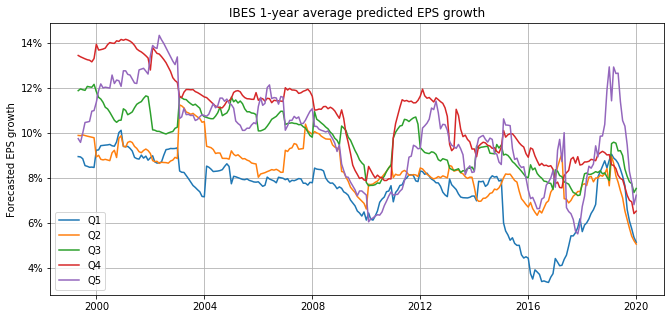

,Q1,Q2,Q3,Q4,Q5
LTG+1,7.47855,8.44627,9.69102,10.7096,9.93351
LTG+2,7.12558,8.16124,9.29543,10.0885,8.52522
LTG+3,6.8088,7.85369,8.97184,9.424,7.49852
LTG+4,6.55439,7.58014,8.62892,8.88681,6.78117
LTG+5,6.31536,7.21858,8.3296,8.47252,6.19405


In [36]:
EPS_plot, EPS_quintiles = AnalystExpectations(duration_monthly, EPS, market_cap)

fig = plt.figure(1, (11,5))
ax = fig.add_subplot(1,1,1)
plt.plot(EPS_plot)
plt.legend(EPS_quintiles.columns)
plt.title("IBES 1-year average predicted EPS growth")
plt.ylabel("Forecasted EPS growth")
plt.grid()
fmt = '%.0f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks);
plt.show()

EPS_quintiles

Finally, Weber looks at the relationship between historical EPS growth and future EPS growth in order to understand why EPS forecasts are high for high-duration firms. The drop in expected long-term growth of high-duration stocks may be due to investors making initial forecasts that are overly optimistic.

Following Weber, I look at the average 5-year (t-5 to t) historical EPS growth rates of the quintile portfolios and compare them to 5-year (t to t+5) subsequent growth rates. The table and plot below indicate that high-duration stocks have higher historical growth rates than low-duration stocks. This difference in growth rates largely disappears in the subsequent 5 years. This may be evidence of **extrapolation bias** in forecasts for long-term growth of high-duration stocks.

In [37]:
def RealizedEarningsGrowth(duration, market_cap, value_weighted=False, lag=60):

    duration = duration.resample('M').last()
    actual_EPS = pd.DataFrame(columns=duration.columns, index=stocks[0].index)
    
    for i in range(len(stocks)):
        actual_EPS[actual_EPS.columns[i]] = stocks[i]["eps_growth"]
    actual_EPS = actual_EPS.resample('M').ffill(limit=12)
    lagged_EPS = actual_EPS.shift(lag)
    actual_EPS = actual_EPS.reindex(duration.index)
    lagged_EPS = lagged_EPS.reindex(duration.index)
    actual_EPS = actual_EPS.rolling(window=lag, min_periods = int(lag/2)).mean()
    lagged_EPS = lagged_EPS.rolling(window=lag, min_periods = int(lag/2)).mean()
    
    results = pd.DataFrame(columns=[1,2,3,4,5], index = ['Lagged EPS','Subsequent EPS'])
    duration = duration.reindex(actual_EPS.index).ffill(limit=12)
    market_cap = market_cap.reindex(actual_EPS.index).ffill(limit=12)
    
    signal = -1*duration.dropna(how='all', axis=[0,1])
    quintiles = signal.apply(lambda x: pd.qcut(x, 5, labels=range(5, 0, -1)), axis=1)
    quintiles = quintiles.reindex(actual_EPS.index).ffill(limit=12)

    if(value_weighted):
        weights = market_cap[signal.columns]
        quintile_weights = dict()
        for q in range(1,6):
            q_weights = pd.DataFrame((quintiles == q).astype(int).values*weights.values, columns=weights.columns, index=weights.index)
            q_weights = q_weights.div(q_weights.sum(axis=1), axis=0)
            quintile_weights[q] = q_weights
        quintile_weights = pd.concat(quintile_weights, axis=1).dropna(how='all', axis=[0, 1])

    else:
        quintile_weights = dict()
        for q in range(1, 6):
            q_weights = (quintiles == q).astype(int)
            q_weights = q_weights.div(q_weights.sum(axis=1), axis=0)
            quintile_weights[q] = q_weights
        quintile_weights = pd.concat(quintile_weights, axis=1).dropna(how='all', axis=[0, 1])
    
    results.iloc[0,:]=quintile_weights.mul(lagged_EPS, axis=0, level=1).sum(axis=1, level=0, min_count=1).median(axis=0)
    results.iloc[1,:]=quintile_weights.mul(actual_EPS, axis=0, level=1).sum(axis=1, level=0, min_count=1).median(axis=0)
    results = results.rename(columns={1: 'Q1',2: 'Q2',3: 'Q3',4: 'Q4',5: 'Q5'})
    return results.T*100

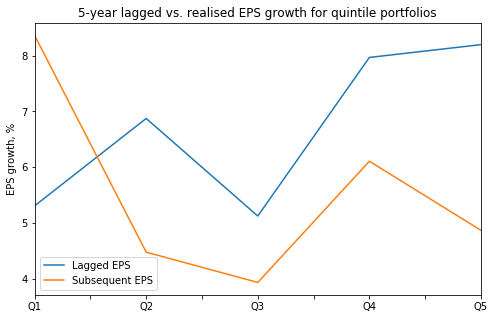

,Lagged EPS,Subsequent EPS
Q1,5.30628,8.36237
Q2,6.87298,4.47681
Q3,5.12446,3.93382
Q4,7.96646,6.10608
Q5,8.19592,4.86782


In [38]:
duration = pd.read_csv("SloanDuration.csv", index_col=0)
duration.index = pd.to_datetime(duration.index)
results = RealizedEarningsGrowth(duration, market_cap)

results.plot(title="5-year lagged vs. realised EPS growth for quintile portfolios", figsize = (8,5))
plt.ylabel("EPS growth, %")
plt.show();
results

## Portfolio Construction

In [21]:
def QuintilePortfolios(daily_returns, duration, market_cap, quintiles, value_weighted=False):

    daily_duration = duration.dropna(how='all', axis=[0, 1]).resample('B').first().ffill(limit=260)
    daily_duration = daily_duration.reindex(daily_returns.index, method = "nearest")

    weights = market_cap.resample('B').ffill(limit=30)
    weights = pd.DataFrame(weights, columns=weights.columns, index=daily_returns.index)

    daily_returns = daily_returns[quintiles.columns]
    quintiles = quintiles.reindex(daily_returns.index, method = "nearest")

    if(value_weighted):
        weights = weights[signal.columns]
        quintile_weights = dict()
        for q in range(1,6):
            q_weights = pd.DataFrame((quintiles == q).astype(int).values*weights.values, columns=weights.columns, index=weights.index)
            q_weights = q_weights.div(q_weights.sum(axis=1), axis=0)
            quintile_weights[q] = q_weights
        quintile_weights = pd.concat(quintile_weights, axis=1).dropna(how='all', axis=[0, 1])
    
    else:
        quintile_weights = dict()
        for q in range(1, 6):
            q_weights = (quintiles == q).astype(int)
            q_weights = q_weights.div(q_weights.sum(axis=1), axis=0)
            quintile_weights[q] = q_weights.resample('B').ffill(limit=7)
        quintile_weights = pd.concat(quintile_weights, axis=1).dropna(how='all', axis=[0, 1])

    quintile_returns = quintile_weights.mul(daily_returns, axis=0, level=1).sum(axis=1, level=0, min_count=1)
    quintile_returns = quintile_returns * (0.10 / (260**0.5 * quintile_returns.std()))
    quintile_returns['duration'] = (quintile_returns[1] - quintile_returns[5])
    quintile_returns = quintile_returns * (0.10 / (260**0.5 * quintile_returns.std()))
    
    q_returns = quintile_weights.mul(daily_returns, axis=0, level=1).sum(axis=1, level=0, min_count=1)
    q_returns['duration'] = (q_returns[1] - q_returns[5])
    
    df = quintile_returns.drop('duration', axis=1)
    df.columns = ['Q{i} (IR = {ir})'.format(i=i, ir=np.round(260**0.5 * df[i].mean() / df[i].std(),2)) for i in df.columns]
    df.cumsum().plot(title='Portfolios Sorted on Cashflow Model (Scaled to 10% Volatility)',
                     figsize=(18, 9));
    return q_returns, quintile_weights, daily_returns

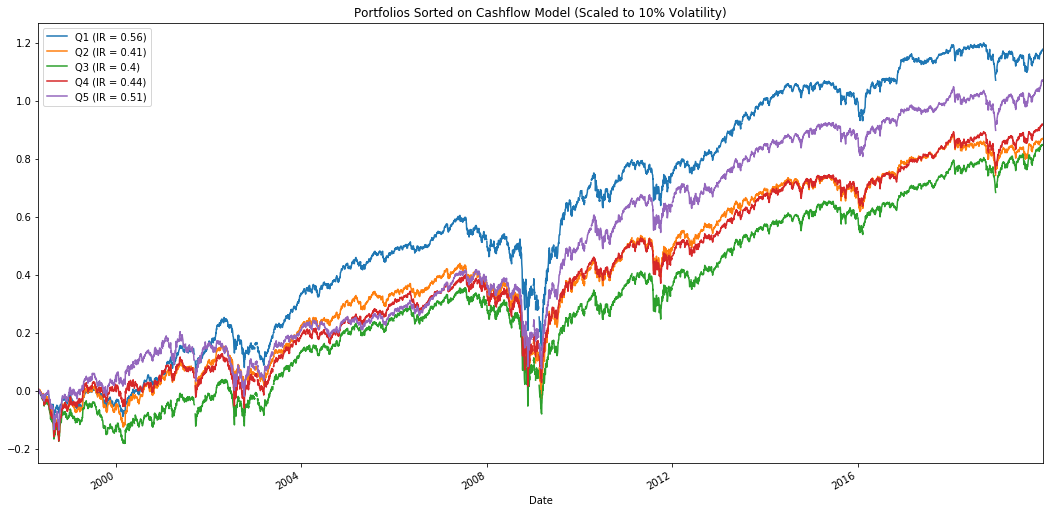

In [22]:
duration = pd.read_csv("SloanDuration.csv", index_col=0)
duration.index = pd.to_datetime(duration.index)

quintile_returns, quintile_weights, daily_returns = QuintilePortfolios(daily_returns, duration, market_cap, quintiles)

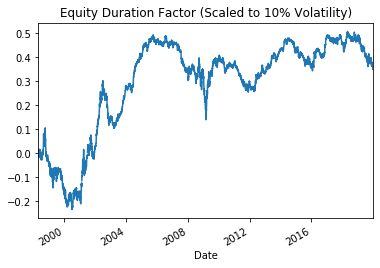

In [23]:
duration = quintile_returns['duration']
duration.cumsum().plot(title='Equity Duration Factor (Scaled to 10% Volatility)');

In [24]:
def FamaFrenchCorrelations(factors, quintile_returns, quintile_weights, daily_returns):

    quintile_returns = quintile_weights.mul(daily_returns, axis=0, level=1).sum(axis=1, level=0, min_count=1)
    quintile_returns['duration'] = (quintile_returns[1] - quintile_returns[5])

    factors_temp = pd.concat((factors,quintile_returns), axis=1, join='inner')
    factors_temp["duration"] = factors_temp["duration"] - factors_temp["rf"]
    del factors_temp["rf"]
    cols = list(factors_temp)
    cols.insert(0, cols.pop(cols.index('duration')))
    factors_temp = factors_temp.ix[:, cols]

    monthly = factors_temp.resample('M').mean()*12
    return monthly

In [25]:
monthly = FamaFrenchCorrelations(factors, quintile_returns, quintile_weights, daily_returns)
corr = round(monthly.corr(),3)
corr.style.background_gradient()

,duration,mktrf,smb,hml,umd,rmw,cma,bab,1,2,3,4,5
duration,1,-0.177,-0.036,0.648,-0.009,0.243,0.463,0.38,0.345,0.154,0.088,-0.011,-0.154
mktrf,-0.177,1,0.264,-0.18,-0.363,-0.451,-0.434,-0.412,0.731,0.774,0.81,0.838,0.863
smb,-0.036,0.264,1,-0.262,0.085,-0.41,-0.244,-0.239,0.227,0.161,0.208,0.211,0.259
hml,0.648,-0.18,-0.262,1,-0.155,0.212,0.602,0.319,0.358,0.283,0.197,0.105,0.036
umd,-0.009,-0.363,0.085,-0.155,1,0.249,0.153,0.362,-0.476,-0.491,-0.473,-0.485,-0.5
rmw,0.243,-0.451,-0.41,0.212,0.249,1,0.379,0.53,-0.262,-0.233,-0.287,-0.293,-0.403
cma,0.463,-0.434,-0.244,0.602,0.153,0.379,1,0.369,-0.02,-0.098,-0.13,-0.192,-0.266
bab,0.38,-0.412,-0.239,0.319,0.362,0.53,0.369,1,-0.148,-0.145,-0.181,-0.241,-0.352
1,0.345,0.731,0.227,0.358,-0.476,-0.262,-0.02,-0.148,1,0.938,0.918,0.888,0.874
2,0.154,0.774,0.161,0.283,-0.491,-0.233,-0.098,-0.145,0.938,1,0.964,0.945,0.908


In [26]:
def factor_regression(x_vals):
    results =[]
    X = monthly[x_vals]
    X = sm.add_constant(X) 
    for i in ["hml", "umd", "rmw", "cma", "bab"]:
        results.append(sm.OLS(monthly[i], X, missing='drop').fit())

    info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
               'No. observations' : lambda x: f"{int(x.nobs):d}"}

    results_table = summary_col(results= results,
                                float_format='%0.3f',
                                stars = True,
                                info_dict=info_dict)
    print(results_table)

In [27]:
def quintile_regression(x_vals, estimate, deciles=False):
    results =[]
    X = monthly[x_vals]
    X = sm.add_constant(X)
    
    
    if(deciles==True):
        for i in [1,2,3,4,5,6,7,8,9,10, estimate]:
            results.append(sm.OLS(monthly[i], X, missing='drop').fit())

        info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
               'No. observations' : lambda x: f"{int(x.nobs):d}"}

        results_table = summary_col(results= results,
                                float_format='%0.3f',
                                stars = True,
                                model_names = ["Q1", "Q2", "Q3", "Q4", "Q5","Q6", "Q7", "Q8", "Q9", "Q10", estimate],
                                info_dict=info_dict)
        print(results_table)

    else:
        
        for i in [1,2,3,4,5, estimate]:
            results.append(sm.OLS(monthly[i], X, missing='drop').fit())

        info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
                   'No. observations' : lambda x: f"{int(x.nobs):d}"}

        results_table = summary_col(results= results,
                                    float_format='%0.3f',
                                    stars = True,
                                    model_names = ["Q1", "Q2", "Q3", "Q4", "Q5", estimate],
                                    info_dict=info_dict)
        print(results_table)

In [28]:
factor_regression(x_vals = "mktrf")


                    hml       umd       rmw       cma       bab   
------------------------------------------------------------------
const            0.001     0.004**   0.003***  0.002***  0.006*** 
                 (0.001)   (0.002)   (0.000)   (0.001)   (0.001)  
mktrf            -0.131*** -0.422*** -0.146*** -0.204*** -0.271***
                 (0.045)   (0.068)   (0.018)   (0.026)   (0.037)  
R-squared        0.03      0.13      0.20      0.19      0.17     
No. observations 260       260       260       260       260      
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [29]:
factor_regression(x_vals = ["mktrf", "smb", "duration"])


                    hml       umd       rmw       cma       bab   
------------------------------------------------------------------
const            0.001     0.004**   0.003***  0.002***  0.006*** 
                 (0.001)   (0.002)   (0.000)   (0.001)   (0.001)  
mktrf            -0.003    -0.498*** -0.109*** -0.153*** -0.209***
                 (0.035)   (0.070)   (0.017)   (0.025)   (0.037)  
smb              -0.242*** 0.318***  -0.143*** -0.094*** -0.132***
                 (0.048)   (0.096)   (0.024)   (0.034)   (0.050)  
duration         0.797***  -0.154    0.095***  0.321***  0.359*** 
                 (0.057)   (0.115)   (0.029)   (0.041)   (0.060)  
R-squared        0.48      0.17      0.32      0.36      0.29     
No. observations 260       260       260       260       260      
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [30]:
quintile_regression(x_vals=["mktrf"], estimate="duration")


                    Q1       Q2       Q3       Q4       Q5     duration
-----------------------------------------------------------------------
const            0.002*   0.001    0.001    0.001    0.001    0.000    
                 (0.001)  (0.001)  (0.001)  (0.001)  (0.001)  (0.001)  
mktrf            0.862*** 0.884*** 0.888*** 0.871*** 0.970*** -0.103***
                 (0.050)  (0.045)  (0.040)  (0.035)  (0.035)  (0.036)  
R-squared        0.53     0.60     0.66     0.70     0.75     0.03     
No. observations 260      260      260      260      260      260      
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [31]:
quintile_regression(x_vals=["mktrf", "smb", "hml", "umd", "rmw", "cma", "bab"], estimate="duration")


                     Q1        Q2        Q3        Q4        Q5    duration
---------------------------------------------------------------------------
const            0.000     -0.001    -0.001    -0.001    0.001     -0.002**
                 (0.001)   (0.001)   (0.001)   (0.001)   (0.001)   (0.001) 
mktrf            0.918***  0.954***  0.945***  0.904***  0.917***  0.005   
                 (0.037)   (0.037)   (0.036)   (0.035)   (0.037)   (0.033) 
smb              0.362***  0.209***  0.215***  0.178***  0.186***  0.178***
                 (0.048)   (0.048)   (0.047)   (0.045)   (0.048)   (0.042) 
hml              0.686***  0.543***  0.363***  0.223***  0.217***  0.461***
                 (0.056)   (0.056)   (0.055)   (0.053)   (0.057)   (0.050) 
umd              -0.215*** -0.220*** -0.202*** -0.203*** -0.202*** -0.019  
                 (0.031)   (0.031)   (0.030)   (0.029)   (0.031)   (0.027) 
rmw              0.190     0.325***  0.156     0.281**   0.009     0.174   
           

## Value-weighted portfolios

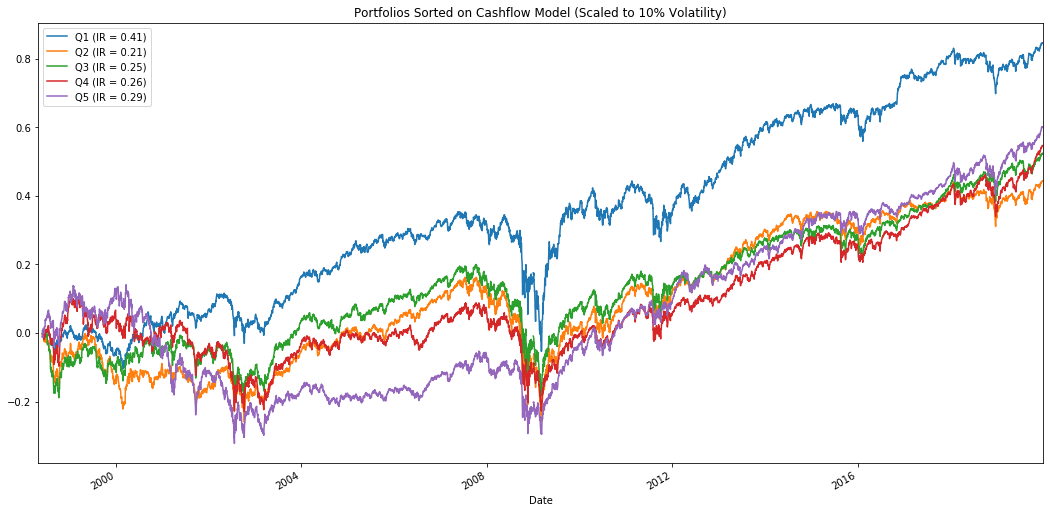

In [39]:
duration = pd.read_csv("SloanDuration.csv", index_col=0)
duration.index = pd.to_datetime(duration.index)

quintile_returns, quintile_weights, daily_returns = QuintilePortfolios(daily_returns, duration, market_cap, quintiles, value_weighted=True)

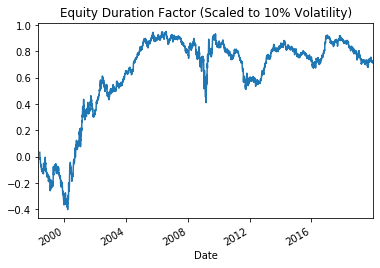

In [40]:
duration = quintile_returns['duration']
duration.cumsum().plot(title='Equity Duration Factor (Scaled to 10% Volatility)');

In [41]:
monthly = FamaFrenchCorrelations(factors, quintile_returns, quintile_weights, daily_returns)
corr = round(monthly.corr(),3)
corr.style.background_gradient()

,duration,mktrf,smb,hml,umd,rmw,cma,bab,1,2,3,4,5
duration,1,-0.038,-0.098,0.722,-0.122,0.082,0.44,0.355,0.579,0.33,0.248,0.007,-0.295
mktrf,-0.038,1,0.251,-0.171,-0.332,-0.455,-0.438,-0.412,0.712,0.723,0.778,0.839,0.872
smb,-0.098,0.251,1,-0.275,0.105,-0.409,-0.249,-0.231,0.066,-0.022,0.104,0.069,0.174
hml,0.722,-0.171,-0.275,1,-0.163,0.22,0.609,0.34,0.371,0.317,0.166,-0.048,-0.271
umd,-0.122,-0.332,0.105,-0.163,1,0.244,0.148,0.332,-0.373,-0.405,-0.43,-0.326,-0.32
rmw,0.082,-0.455,-0.409,0.22,0.244,1,0.365,0.511,-0.244,-0.168,-0.297,-0.263,-0.367
cma,0.44,-0.438,-0.249,0.609,0.148,0.365,1,0.365,-0.013,-0.013,-0.137,-0.264,-0.446
bab,0.355,-0.412,-0.231,0.34,0.332,0.511,0.365,1,-0.088,-0.081,-0.19,-0.314,-0.444
1,0.579,0.712,0.066,0.371,-0.373,-0.244,-0.013,-0.088,1,0.843,0.821,0.717,0.607
2,0.33,0.723,-0.022,0.317,-0.405,-0.168,-0.013,-0.081,0.843,1,0.887,0.789,0.667


In [42]:
factor_regression(x_vals = ["mktrf", "smb", "duration"])


                    hml       umd       rmw       cma       bab   
------------------------------------------------------------------
const            0.000     0.004**   0.003***  0.002***  0.006*** 
                 (0.001)   (0.002)   (0.000)   (0.001)   (0.001)  
mktrf            -0.075**  -0.461*** -0.128*** -0.192*** -0.264***
                 (0.032)   (0.071)   (0.018)   (0.025)   (0.038)  
smb              -0.176*** 0.303***  -0.137*** -0.069**  -0.098*  
                 (0.042)   (0.093)   (0.024)   (0.032)   (0.050)  
duration         0.552***  -0.147**  0.013     0.210***  0.243*** 
                 (0.032)   (0.072)   (0.019)   (0.025)   (0.039)  
R-squared        0.57      0.16      0.30      0.38      0.30     
No. observations 259       259       259       259       259      
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [43]:
quintile_regression(x_vals=["mktrf"], estimate = "duration")


                    Q1       Q2       Q3       Q4       Q5    duration
----------------------------------------------------------------------
const            0.001    -0.000   -0.000   -0.000   -0.000   0.001   
                 (0.001)  (0.001)  (0.001)  (0.001)  (0.001)  (0.001) 
mktrf            0.824*** 0.760*** 0.812*** 0.805*** 0.865*** -0.037  
                 (0.051)  (0.045)  (0.041)  (0.033)  (0.030)  (0.060) 
R-squared        0.51     0.52     0.61     0.70     0.76     0.00    
No. observations 259      259      259      259      259      259     
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [44]:
quintile_regression(x_vals=["mktrf", "smb", "hml", "umd", "rmw", "cma", "bab"], estimate="duration")


                    Q1        Q2        Q3        Q4        Q5    duration
--------------------------------------------------------------------------
const            -0.000   -0.002*** -0.001    -0.001    0.000     -0.001  
                 (0.001)  (0.001)   (0.001)   (0.001)   (0.001)   (0.001) 
mktrf            0.954*** 0.929***  0.878***  0.891***  0.844***  0.114** 
                 (0.044)  (0.040)   (0.043)   (0.039)   (0.036)   (0.050) 
smb              0.029    -0.083*   0.019     -0.123*** -0.075*   0.106*  
                 (0.053)  (0.048)   (0.052)   (0.046)   (0.043)   (0.059) 
hml              0.648*** 0.400***  0.241***  0.016     -0.187*** 0.826***
                 (0.065)  (0.060)   (0.064)   (0.057)   (0.053)   (0.073) 
umd              -0.074** -0.121*** -0.155*** -0.027    -0.039    -0.041  
                 (0.035)  (0.032)   (0.035)   (0.031)   (0.029)   (0.040) 
rmw              -0.083   0.192     -0.023    0.314***  0.234**   -0.322**
                 (0.134)